In [2]:
import numpy as np
import matplotlib.pyplot as plt

## FrozenLake grid environment

Similar to https://gymnasium.farama.org/environments/toy_text/frozen_lake/

cell colors:

* blue - start cell
* white - empty cell
* red - hole, reward -1
* green - goal, reward +100

actions are slippery:
* P(move forward)=1/3
* P(move left)=1/3
* P(move right)=1/3

rewards:
* hole reward -1
* goal reward +100
* out of grid reward 0, agent doesn't move

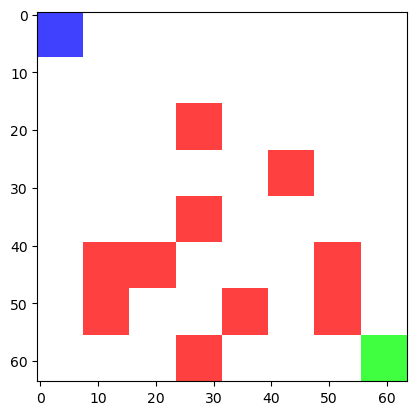

In [6]:
DIRECTIONS = [
    (-1, 0),
    (0, 1),
    (1, 0),
    (0, -1)
]

class FrozenLakeSimple:
    def __init__(self):
        self.N = 8
        self.board = [
            "SFFFFFFF",
            "FFFFFFFF",
            "FFFHFFFF",
            "FFFFFHFF",
            "FFFHFFFF",
            "FHHFFFHF",
            "FHFFHFHF",
            "FFFHFFFG",
        ]
        self.start = (0, 0)

    def render(self):
        N = self.N
        board = self.board
        CELL_SIZE = 8

        img = np.zeros((N * CELL_SIZE, N * CELL_SIZE, 3), dtype=np.uint8)
        for r in range(N):
            for c in range(N):
                colors = {
                    'S': [64, 64, 255],
                    'F': [255, 255, 255],
                    'H': [255, 64, 64],
                    'G': [64, 255, 64],
                }
                img[r * CELL_SIZE : (r + 1) * CELL_SIZE, c * CELL_SIZE : (c + 1) * CELL_SIZE, :] = colors[board[r][c]]
        plt.imshow(img)

    def get_reward_done(self, row, col):
        """
        Return reward for getting into the state (row, col)
        Return done flag
        """
        board = self.board

        sym = board[row][col]

        rewards = {'S': 0, 'H': -1, 'G': 100, 'F': 0}
        reward = rewards[sym]

        done = sym in 'HG'

        return reward, done

    def yield_transitions(self, row, col, action_idx):
        """
        Get possible transitions from state `(row, col)` and action `action_idx`
        Yield tuples `(transition probability, new state row, new state col)`
        """

        N = self.N

        # next state decided by picked action and slippery (modify action with probability 1/3)
        for delta_action_idx in range(-1, 2):

            true_action_idx = (action_idx + delta_action_idx) % 4

            dr, dc = DIRECTIONS[true_action_idx]
            next_row, next_col = row + dr, col + dc

            if 0 <= next_row < N and 0 <= next_col < N:

                yield (1.0 / 3, next_row, next_col)

problem = FrozenLakeSimple()
problem.render()

In [7]:
def get_constant_policy(problem, dir):
    policy = np.zeros((problem.N, problem.N, 4))
    policy[:, :, dir] = 1
    return policy

def get_random_policy(problem):
    policy = np.random.rand(problem.N, problem.N, 4)
    for row in range(problem.N):
        for col in range(problem.N):
            policy[row, col, :] /= np.sum(policy[row, col, :])
    return policy

def show_policy_and_policy_state_function(problem, policy, policy_state_function):

    def __show_board(values_array, ax, title, show_actions, show_values):
        N, M = values_array.shape
        CELL_SIZE = 100

        img = np.ones((N * CELL_SIZE + 1, M * CELL_SIZE + 1, 3), dtype=np.uint8) * 255

        for r, c in np.ndindex(values_array.shape):
            colors = {
                'S': [64, 64, 255],
                'F': [255, 255, 255],
                'H': [255, 64, 64],
                'G': [64, 255, 64],
            }
            img[r * CELL_SIZE : (r + 1) * CELL_SIZE, c * CELL_SIZE : (c + 1) * CELL_SIZE, :] = colors[problem.board[r][c]]

        for r in range(N + 1):
            img[r * CELL_SIZE, :, :] = 0
        for c in range(M + 1):
            img[:, c * CELL_SIZE, :] = 0

        if show_actions:
            for r, c in np.ndindex(values_array.shape):
                rpos = r * CELL_SIZE + CELL_SIZE // 2
                cpos = c * CELL_SIZE + CELL_SIZE // 2

                action = np.argmax(policy[r, c, :])
                dr, dc = DIRECTIONS[action]

                r1 = rpos + dr * CELL_SIZE // 3
                c1 = cpos + dc * CELL_SIZE // 3

                img[min(rpos, r1) : max(rpos, r1) + 2, min(cpos, c1) : max(cpos, c1) + 2, :] = 0

        ax.imshow(img)
        ax.axis('off')
        if show_values:
            for r, c in np.ndindex(values_array.shape):
                x = c * CELL_SIZE + CELL_SIZE // 10
                y = r * CELL_SIZE + CELL_SIZE // 2
                s = "{0:<4}".format(str(round(values_array[r, c], 4)))
                ax.text(x, y, s)

        ax.set_title(title)

    fig, ax = plt.subplots(nrows=2, ncols=3)
    fig.set_size_inches(30, 20)
    ax = ax.reshape(-1, 3)

    __show_board(policy[:, :, 0], ax[0, 0], "Probabilities to go UP", show_actions=False, show_values=True)
    __show_board(policy[:, :, 1], ax[0, 1], "Probabilities to go RIGHT", show_actions=False, show_values=True)
    __show_board(policy[:, :, 2], ax[0, 2], "Probabilities to go DOWN", show_actions=False, show_values=True)
    __show_board(policy[:, :, 3], ax[1, 0], "Probabilities to go LEFT", show_actions=False, show_values=True)
    __show_board(policy_state_function, ax[1, 1], "Selected actions", show_actions=True, show_values=False)
    __show_board(policy_state_function, ax[1, 2], "Policy State values", show_actions=False, show_values=True)

## Monte-Carlo First-Visit

Book "Reinforcement Learning An Introduction" by Sutton and Barto, second edition, page 92, 5.1 - Monte Carlo Prediction

/tmp/ipykernel_77623/456820263.py:54: RuntimeWarning: invalid value encountered in divide
  return state_rewards_sum / state_rewards_count


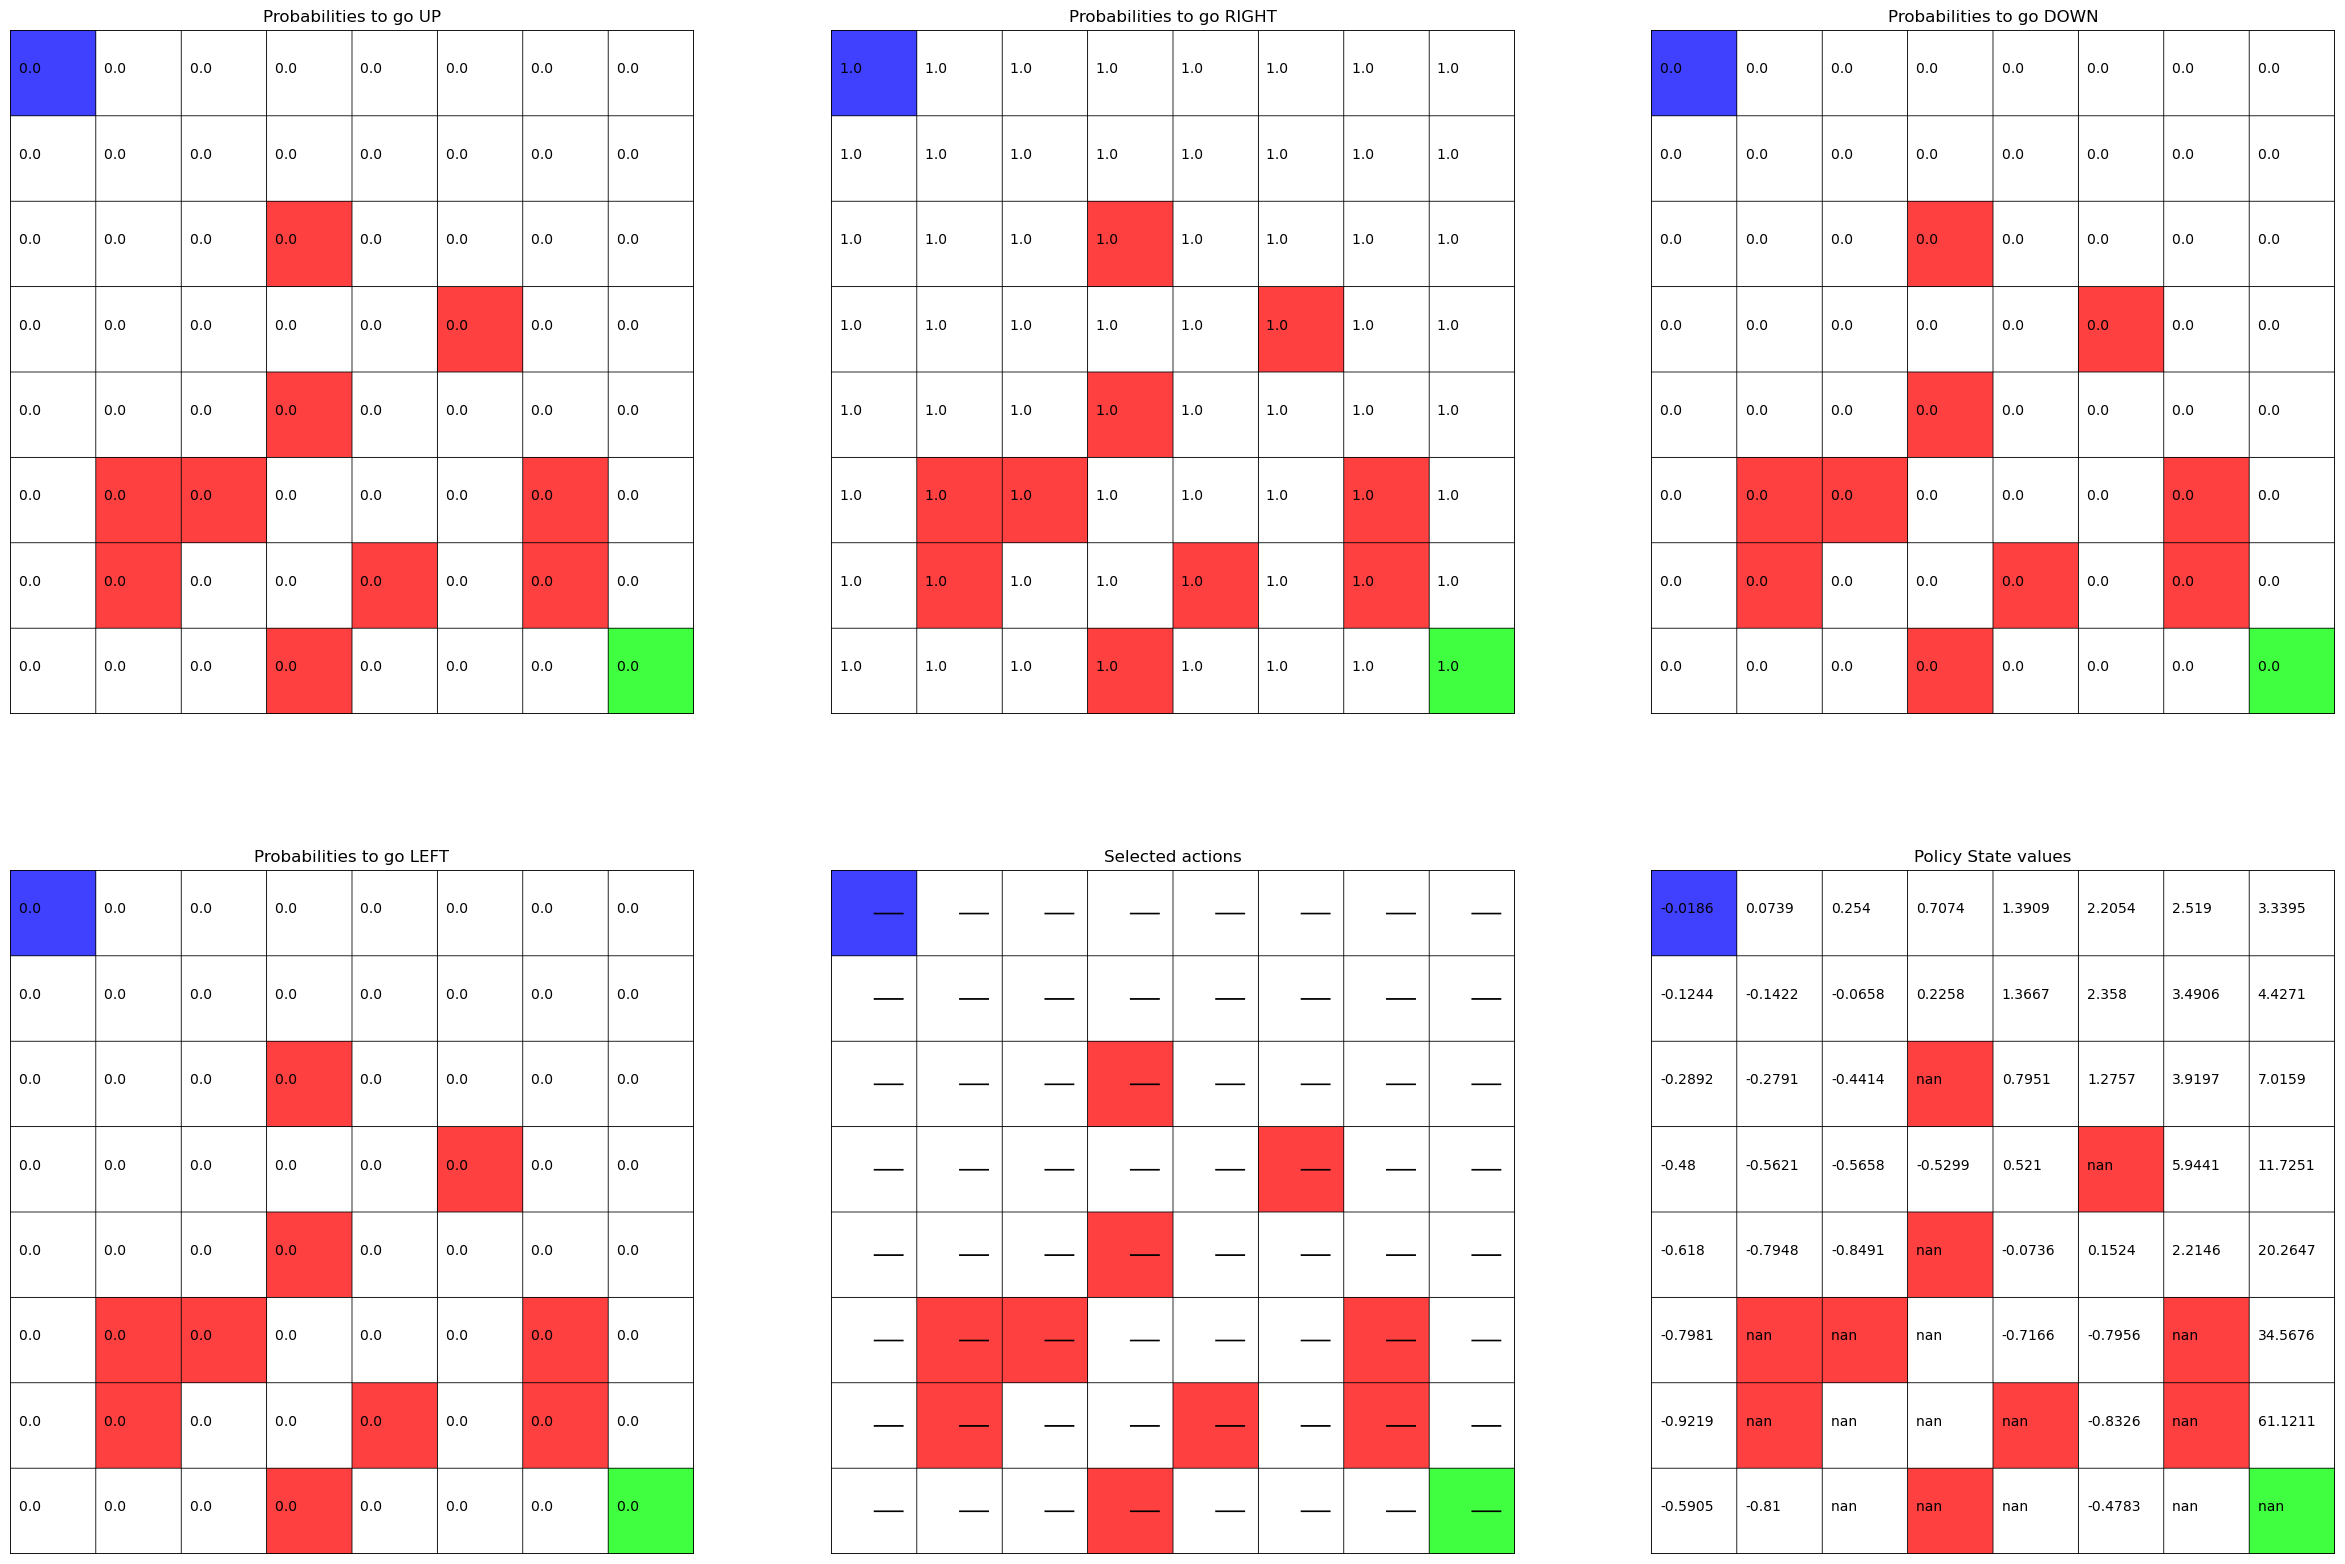

In [15]:
def evaluate_policy_state__monte_carlo_first_visit(problem, policy, discount_factor, n_runs):
    N = problem.N
    state_rewards_sum = np.zeros((N, N), dtype=np.float32)
    state_rewards_count = np.zeros((N, N), dtype=np.int32)

    startrow, startcol = problem.start

    for n_run in range(n_runs):

        # Generate episode following policy
        time_first_seen = dict()   # (row, col) -> time of first appearance
        episode_states = []   # [ start_state, state1, state2, state3, ... ]
        episode_rewards = []  # [ reward1, reward2, reward3, ... ]

        row, col = startrow, startcol
        for time in range(1000):

            if (row, col) not in time_first_seen:
                time_first_seen[(row, col)] = time

            episode_states.append((row, col))

            action_idx = np.random.choice([0, 1, 2, 3], p=policy[row, col, :])

            # apply slippery
            action_idx += np.random.randint(-1, 2)
            action_idx %= 4

            dr, dc = DIRECTIONS[action_idx]
            next_row, next_col = row + dr, col + dc

            if 0 <= next_row < N and 0 <= next_col < N:
                row, col = next_row, next_col

            reward, done = problem.get_reward_done(row, col)

            episode_rewards.append(reward)

            if done:
                break

        # Compute policy state values
        G = 0
        for time in range(len(episode_states) - 1, -1, -1):
            state_t = episode_states[time]
            reward_t_plus_1 = episode_rewards[time]

            G = discount_factor * G + reward_t_plus_1

            if time_first_seen[state_t] == time:
                state_rewards_sum[state_t] += G
                state_rewards_count[state_t] += 1

    return state_rewards_sum / state_rewards_count

policy = get_constant_policy(problem, dir=1)  # Always right
policy_state_function = evaluate_policy_state__monte_carlo_first_visit(problem, policy, discount_factor=0.9, n_runs=1000)
show_policy_and_policy_state_function(problem, policy, policy_state_function)

# Monte-Carlo Every-Visit

same as first-visit, except without the check for St having occured earlier in the episode

/tmp/ipykernel_77623/466691972.py:49: RuntimeWarning: invalid value encountered in divide
  return state_rewards_sum / state_rewards_count


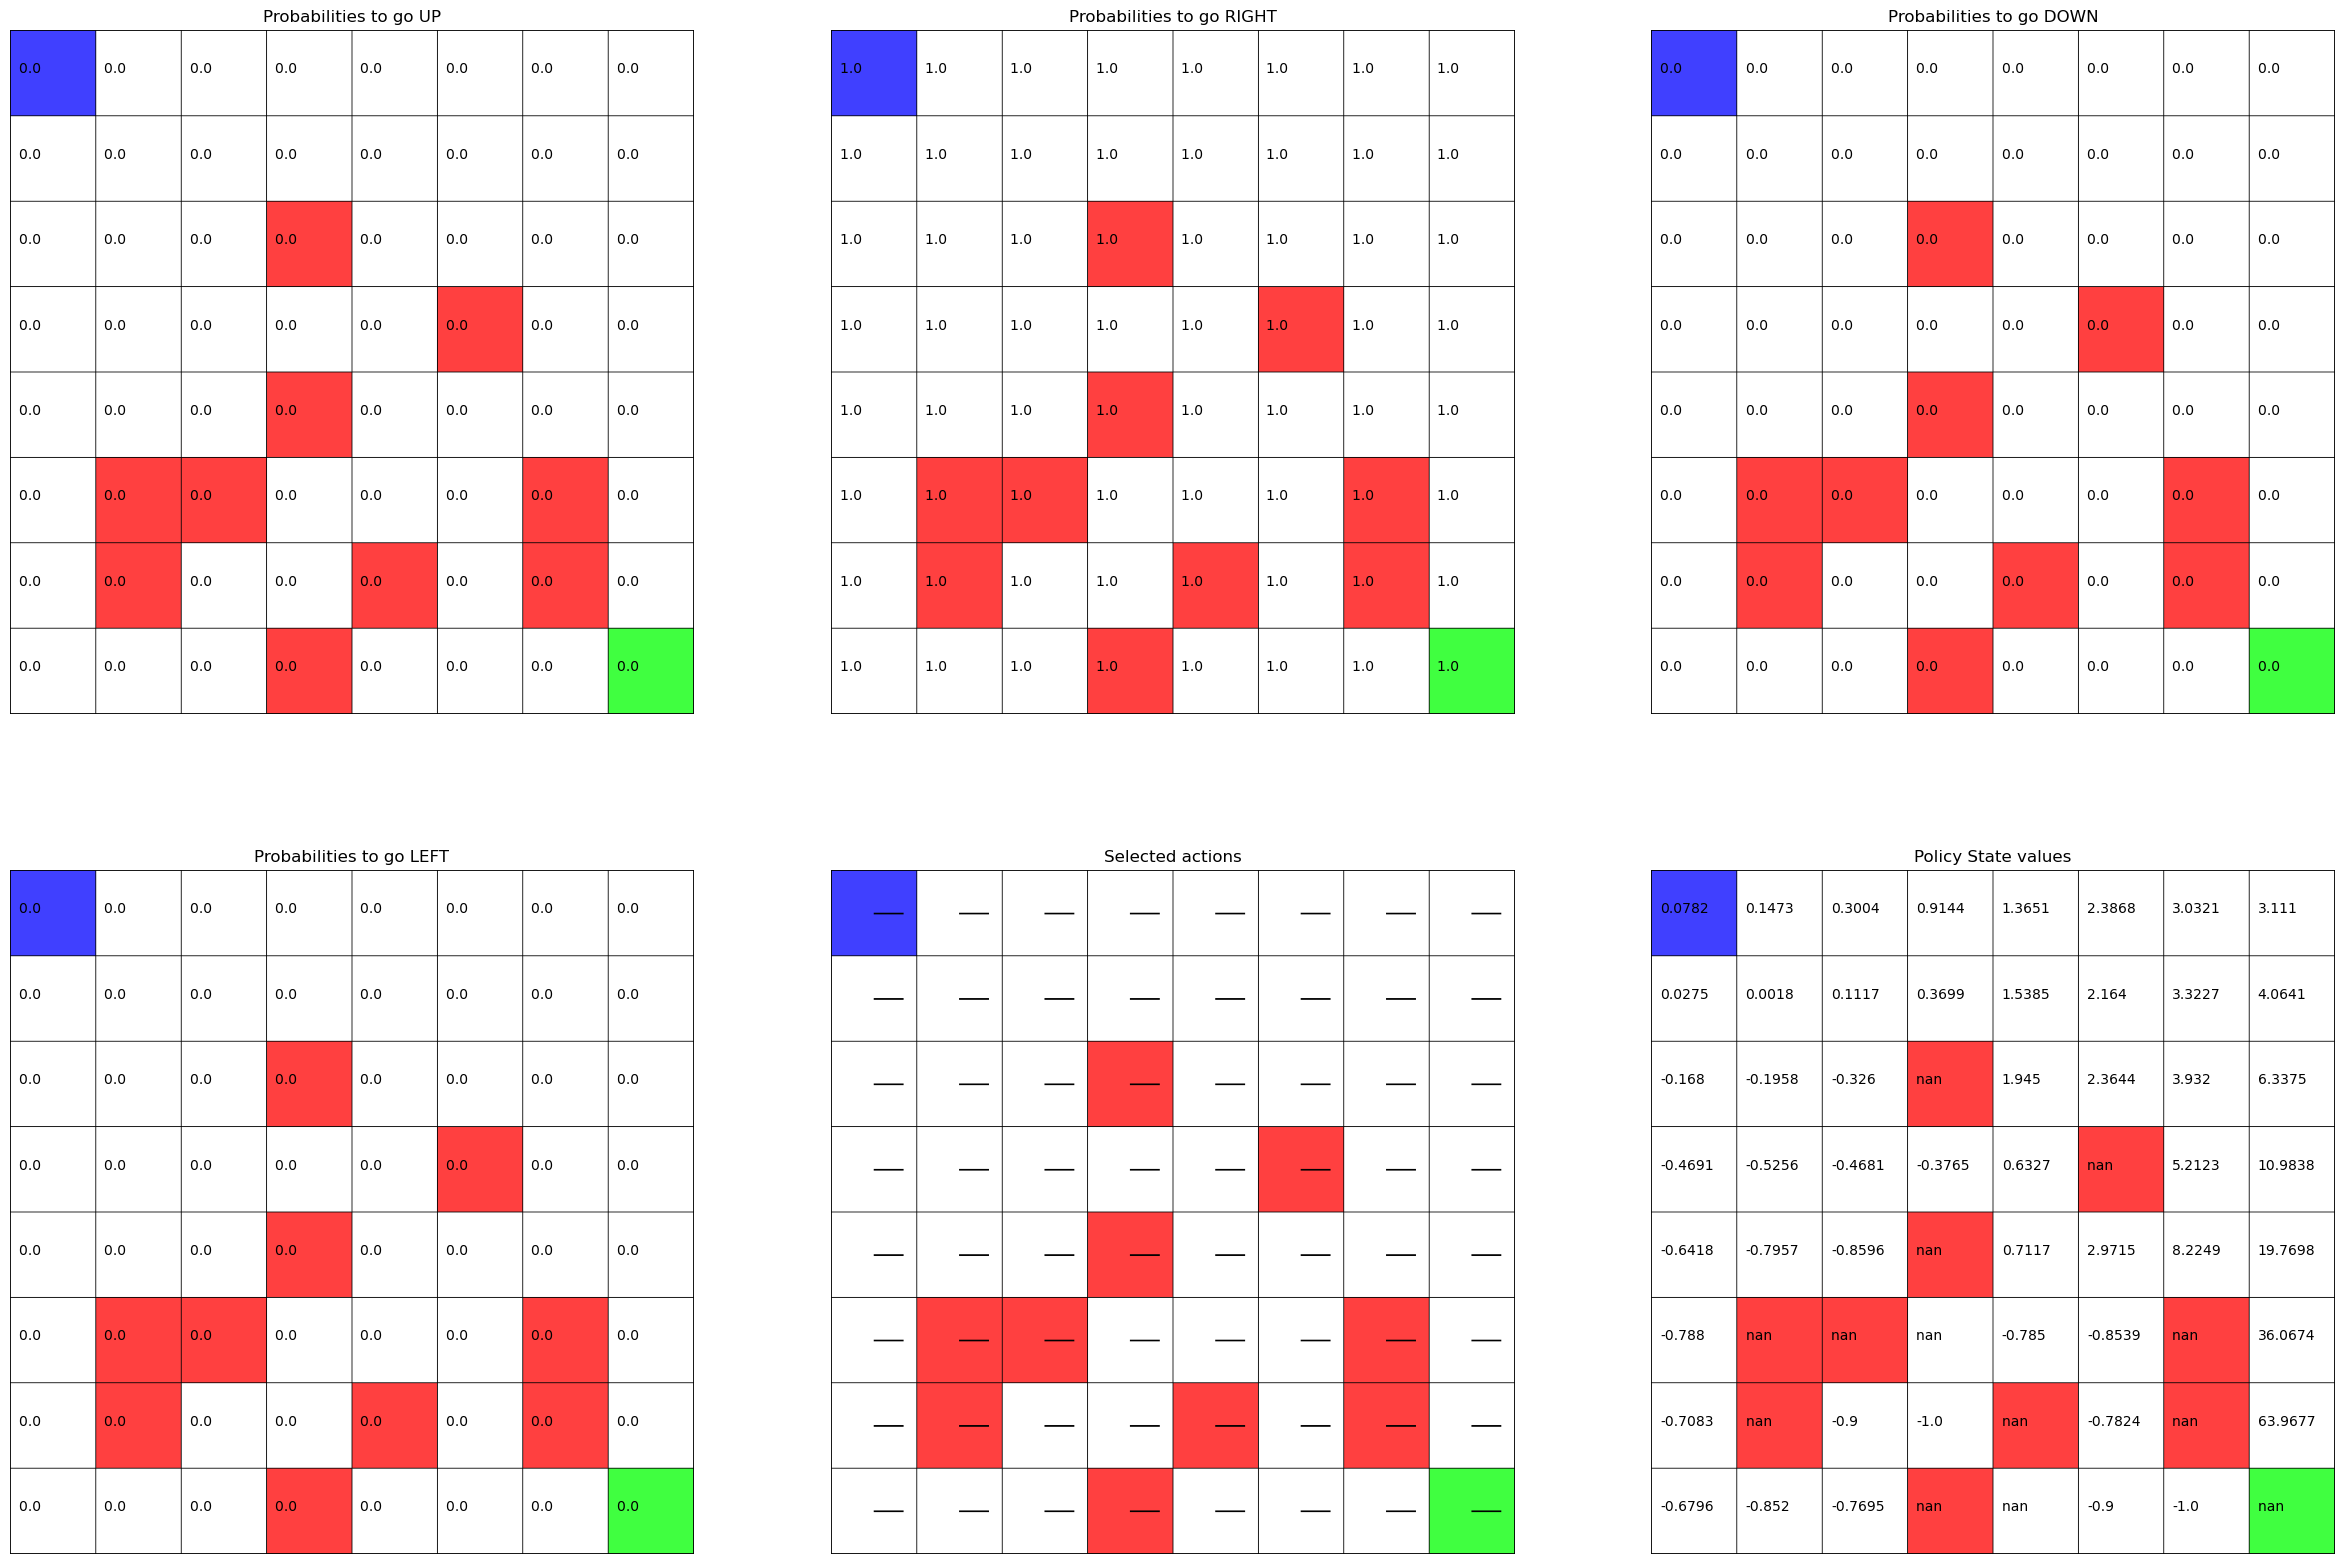

In [16]:
def evaluate_policy_state__monte_carlo_every_visit(problem, policy, discount_factor, n_runs):
    N = problem.N
    state_rewards_sum = np.zeros((N, N), dtype=np.float32)
    state_rewards_count = np.zeros((N, N), dtype=np.int32)

    startrow, startcol = problem.start

    for n_run in range(n_runs):

        # Generate episode following policy
        episode_states = []   # [ start_state, state1, state2, state3, ... ]
        episode_rewards = []  # [ reward1, reward2, reward3, ... ]

        row, col = startrow, startcol
        for time in range(1000):

            episode_states.append((row, col))

            action_idx = np.random.choice([0, 1, 2, 3], p=policy[row, col, :])

            # apply slippery
            action_idx += np.random.randint(-1, 2)
            action_idx %= 4

            dr, dc = DIRECTIONS[action_idx]
            next_row, next_col = row + dr, col + dc

            if 0 <= next_row < N and 0 <= next_col < N:
                row, col = next_row, next_col

            reward, done = problem.get_reward_done(row, col)

            episode_rewards.append(reward)

            if done:
                break

        # Compute policy state values
        G = 0
        for time in range(len(episode_states) - 1, -1, -1):
            state_t = episode_states[time]
            reward_t_plus_1 = episode_rewards[time]

            G = discount_factor * G + reward_t_plus_1

            state_rewards_sum[state_t] += G
            state_rewards_count[state_t] += 1

    return state_rewards_sum / state_rewards_count

policy = get_constant_policy(problem, dir=1)  # Always right
policy_state_function = evaluate_policy_state__monte_carlo_every_visit(problem, policy, discount_factor=0.9, n_runs=1000)
show_policy_and_policy_state_function(problem, policy, policy_state_function)

# Monte-Carlo Exploring Starts

Book "Reinforcement Learning An Introduction" by Sutton and Barto, second edition, page 99, 5.3 - Monte Carlo Control

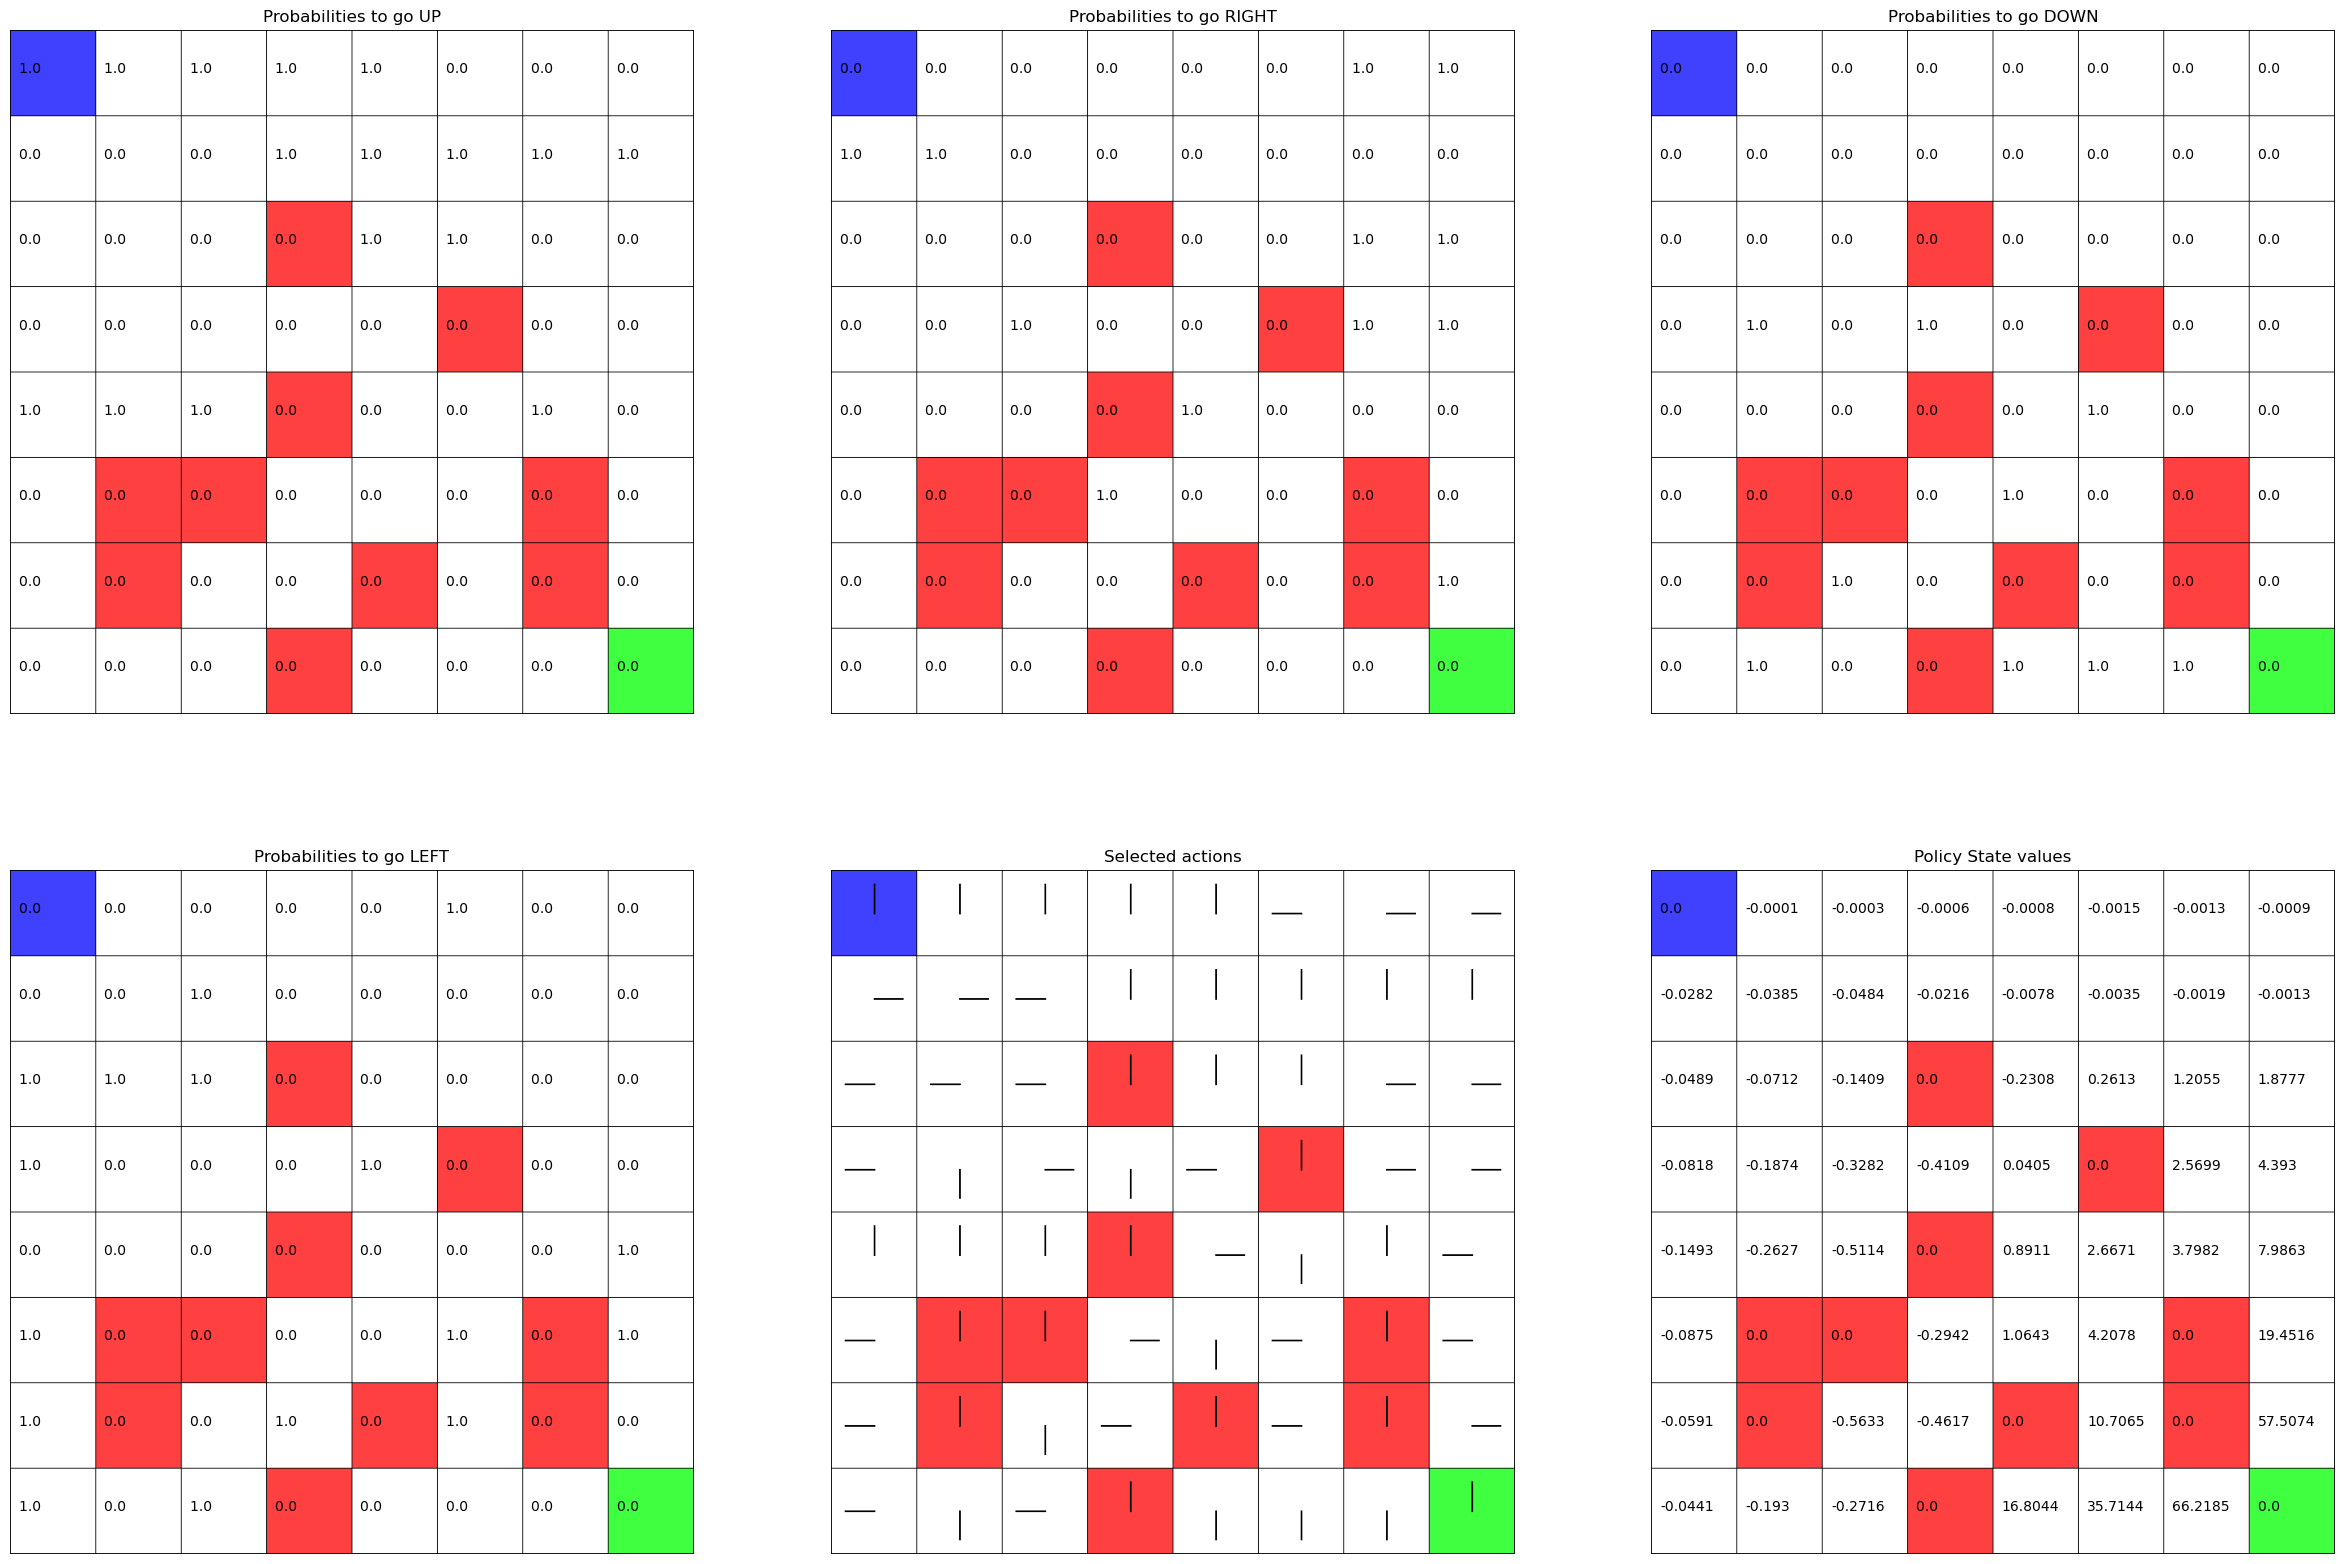

In [22]:
def monte_carlo_exploring_starts(problem, discount_factor, n_runs):
    N = problem.N

    policy = np.random.rand(problem.N, problem.N, 4)

    q_values = np.random.rand(problem.N, problem.N, 4)

    returns_sum = np.zeros((N, N, 4), dtype=np.float32)
    returns_count = np.zeros((N, N, 4), dtype=np.int32)

    # Ignore terminal states
    for row, col in np.ndindex((N, N)):
        if problem.board[row][col] in 'HG':
            policy[row, col, :] = 0
            q_values[row, col] = 0
        else:
            policy[row, col, :] /= np.sum(policy[row, col, :])

    for n_run in range(n_runs):

        while True:
            startrow = np.random.randint(0, N)
            startcol = np.random.randint(0, N)
            if problem.board[startrow][startcol] not in 'HG':
                break

        start_action_idx = np.random.choice([0, 1, 2, 3], p=policy[startrow, startcol, :])

        # Generate episode following policy
        time_first_seen = dict()   # (row, col, action_idx) -> time of first appearance
        episode_states = []   # [ start_state, state1, state2, state3, ... ]
        episode_actions = []  # [ start_action, action1, action2, action3, ... ]
        episode_rewards = []  # [ reward1, reward2, reward3, ... ]

        row, col = startrow, startcol
        for time in range(1000):

            episode_states.append((row, col))

            action_idx = start_action_idx if time == 0 else np.random.choice([0, 1, 2, 3], p=policy[row, col, :])

            episode_actions.append(action_idx)

            if (row, col, action_idx) not in time_first_seen:
                time_first_seen[(row, col, action_idx)] = time

            # apply slippery
            action_idx += np.random.randint(-1, 2)
            action_idx %= 4

            dr, dc = DIRECTIONS[action_idx]
            next_row, next_col = row + dr, col + dc

            if 0 <= next_row < N and 0 <= next_col < N:
                row, col = next_row, next_col

            reward, done = problem.get_reward_done(row, col)

            episode_rewards.append(reward)

            if done:
                break

        # Compute policy state values
        G = 0
        for time in range(len(episode_states) - 1, -1, -1):
            state_t_row, state_t_col = episode_states[time]
            action_t = episode_actions[time]
            reward_t_plus_1 = episode_rewards[time]

            G = discount_factor * G + reward_t_plus_1

            if time_first_seen[(state_t_row, state_t_col, action_t)] == time:
                returns_sum[state_t_row, state_t_col, action_t] += G
                returns_count[state_t_row, state_t_col, action_t] += 1
                q_values[state_t_row, state_t_col, action_t] = returns_sum[state_t_row, state_t_col, action_t] / returns_count[state_t_row, state_t_col, action_t]
                policy[state_t_row, state_t_col, :] = 0
                policy[state_t_row, state_t_col, np.argmax(q_values[state_t_row, state_t_col, :])] = 1

    # Compute policy_state_function
    policy_state_function = np.zeros((N, N))
    for row, col in np.ndindex((N, N)):
        policy_state_function[row, col] = max(q_values[row, col, :])

    return policy, policy_state_function

policy, policy_state_function = monte_carlo_exploring_starts(problem, discount_factor=0.9, n_runs=10000)
show_policy_and_policy_state_function(problem, policy, policy_state_function)

# Racetrack environment

1 -1 0


TypeError: exceptions must derive from BaseException

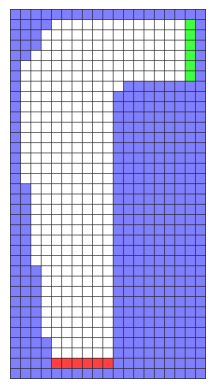

In [67]:
class Racetrack:
    def __init__(self):
        self.OFFGRID = -1
        self.ROAD = 0
        self.START = 1
        self.FINISH = 2

        board = -np.ones((36, 19))
        for ri, (start, length) in enumerate(
                [(4, 13), (3, 14), (3, 14), (2, 15), (1, 16), (1, 16), (1, 10)] +
                [(1, 9) for _ in range(9)] +
                [(2, 8) for _ in range(8)] +
                [(3, 7) for _ in range(7)] +
                [(4, 6), (4, 6)]):
            board[ri + 1, start : start + length] = self.ROAD
        board[-2, 4:10] = self.START
        board[1:7, 17] = self.FINISH
        self.board = board
        self.start_positions = []
        for r, c in np.ndindex(board.shape):
            if board[r, c] == self.START:
                self.start_positions.append((r, c))

    def render(self):
        board = self.board
        N, M = board.shape
        CELL_SIZE = 16

        img = np.ones((N * CELL_SIZE + 1, M * CELL_SIZE + 1, 3), dtype=np.uint8) * 32

        for r, c in np.ndindex(board.shape):
            colors = {
                self.OFFGRID: [128, 128, 255],  # offgrid
                self.ROAD: [255, 255, 255], # road
                self.START: [255, 64, 64],   # start
                self.FINISH: [64, 255, 64],   # finish
            }
            img[r * CELL_SIZE + 1 : (r + 1) * CELL_SIZE, c * CELL_SIZE + 1 : (c + 1) * CELL_SIZE, :] = colors[board[r, c]]
        plt.imshow(img)
        plt.axis('off')

    def create_random_policy(self):
        board = self.board
        N, M = board.shape
        policy = np.random.rand(N, M, 5, 5, 9)
        for r, c, vr, vc in np.ndindex((N, M, 5, 5)):
            policy[r, c, vr, vc, :] /= np.sum(policy[r, c, vr, vc, :])
        return policy

    def generate_run(self, policy):
        board = self.board
        N, M = board.shape
        assert policy.shape == (N, M, 5, 5, 9)   # (pos_row, pos_col, velocity_row, velocity_col, action) -> probablity

        start_pos = self.start_positions[np.random.randint(0, len(self.start_positions))]
        start_state = (start_pos[0], start_pos[1], 0, 0)    # pos_row, pos_col, velocity_row, velocity_col

        sar_array = [start_state]   # (state0, action0, reward1, state1, action1, reward2, ...)

        while True:
            pos_row, pos_col, velocity_row, velocity_col = sar_array[-1]

            action_idx = np.random.choice(9, p=policy[pos_row, pos_col, velocity_row, velocity_col, :])
            action_delta_row, action_delta_col = action_idx // 3 - 1, action_idx % 3 - 1

            if np.random.rand() <= 0.1:
                action_delta_row, action_delta_col = 0, 0

            new_vel_row, new_vel_col = velocity_row + action_delta_row, velocity_col + action_delta_col

            if new_vel_row == 0 and new_vel_col == 0:
                

            print(action_idx, action_delta_row, action_delta_col)
            raise 1


problem = Racetrack()
problem.render()
run = problem.generate_run(problem.create_random_policy())
print(run)